# Car Pricing Predictor
- A statistical model built to predict the initial price of a car given a car make's characteristics (location, year, fuel type, transmission type, engine, etc.).

- This notebook contains examples running regression estimations on the Cars dataset. Our target variable is price($CAD) of the car.

We can sketch out the process as follows:
* [1. Define the problem](#first-bullet)
* [2. Obtain the Data](#second-bullet)
* [3. Data Cleaning](#third-bullet)
* [4. Exploratory Data Analysis](#four-bullet)
* [5. Model the data](#fifth-bullet)
* [6. Conclusion](#sixth-bullet)

## 1. Define the Problem  <a class="anchor" id="first-bullet"></a>

Based on this dataset, we are running examples of regression estimations on the cars details to predict thhe price of other cars, given the same listing categories.


Note that the extracted data of 'Price' is defaulted to Lakh (IR), to be converted to Canadian Dollar (CAD).

## 2. Obtain the Data  <a class="anchor" id="second-bullet"></a>

In [7]:
# import libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # this is to clear the warnings from this page, typically you would leave them on

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, LassoCV, ElasticNetCV, RANSACRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer


from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.pipeline import make_pipeline


from sklearn.metrics import confusion_matrix
import sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
data = pd.read_csv('data/train.csv')

FileNotFoundError: [Errno 2] File b'data/train.csv' does not exist: b'data/train.csv'

In [ ]:
# set to display all columns
pd.set_option('display.max_columns', 500)
data.head(10)

1. Name is a combination of make + model. The make will be extracted from this column.
2. Mileage has different units (km/kg & kmpl), will convert them all to a common unit
3. Engine and Power units are consistent in the columns and those can be dropped.
4. Price is currently Lahk, will convert to CAD.

In [ ]:
# drop 'Unnamed: 0' column, redundant
data = data.drop('Unnamed: 0', axis=1)

### 2.1. Naive Model & Benchmark

In [ ]:
data['Price'].mean()

In [ ]:
# how to fit this into a model 

In [5]:
data.info()

NameError: name 'data' is not defined

In [6]:
data.describe()

NameError: name 'data' is not defined

In [8]:
data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

1. New_Price have more than 86% missing. As our target is the 'Price', this column will be dropped.
2. Mileage, Engine, Power, Seats have very few missing - can be addressed by filling mean, median or mode.


# INR to CAD (as of 01/2020: 1 INR = 0.018230 CAD) and save to new files

In [3]:
data['New_Price']

NameError: name 'data' is not defined

In [4]:
data['New_Price'].split(' ')[0]

NameError: name 'data' is not defined

In [5]:
data['New_Price'] = data['New_Price'].str.strip(' Lakh').astype(float)

NameError: name 'data' is not defined

In [20]:
for new in data['New_Price']:
    print(new)
    if not pd.isnull(new):
        if new.split(' ')[1] == 'Lakh':
            data['New_Price'] = data['New_Price'].str.strip(' Lakh').astype(float) 

        elif new.split(' ')[1] == 'Cr':
            data['New_Price'] = data['New_Price'].str.strip(' Cr').astype(float)*100
        else:
            pass

nan
nan
8.61 Lakh


ValueError: could not convert string to float: '1.28 Cr'

In [5]:
i = 0 
for i in data['New_Price'][i]:
    for new in data['New_Price']:
        if not pd.isnull(new):
            if new.split(' ')[1] == 'Lakh':
                new = float(new.split(' ')[0])
                data['New_Price'][i] = new
            elif new.split(' ')[1] == 'Cr':
                new = (float(new.split(' ')[0]) * 100)
                data['New_Price'][i] = new
            else:
                pass

TypeError: 'float' object is not iterable

In [109]:
data['New_Price']

0             NaN
1             NaN
2       8.61 Lakh
3             NaN
4             NaN
          ...    
6014    7.88 Lakh
6015          NaN
6016          NaN
6017          NaN
6018          NaN
Name: New_Price, Length: 6019, dtype: object

## 3. Data Cleaning <a class="anchor" id="third-bullet"></a>

To check for proper formats, incorrect entries, etc.
1. We will drop 'Kilometers_Driven' and 'New_Price' as they do not correlate to 'Price'
2.

Convert Mileage to the most common unit (kmpl).
Remove units for Mileage, Engine and Power.
Convert Price from Lahk to CAD.



In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
Name                 6019 non-null object
Location             6019 non-null object
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null object
Transmission         6019 non-null object
Owner_Type           6019 non-null object
Mileage              6017 non-null object
Engine               5983 non-null object
Power                5983 non-null object
Seats                5977 non-null float64
New_Price            824 non-null object
Price                6019 non-null float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


In [30]:
data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

1. New_Price have more than 86% missing need to address, this column seems important to compare price between new car & used car price.
2. Mileage, Engine, Power, Seats have very few missing this can be addressed by filling mean, median or mode to avoid losing data

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,6019.0,2013.358199,3.269742,1998.00,2011.0,2014.00,2016.00,2019.0
Kilometers_Driven,6019.0,58738.380296,91268.843206,171.00,34000.0,53000.00,73000.00,6500000.0
Seats,5977.0,5.278735,0.808840,0.00,5.0,5.00,5.00,10.0
Price,6019.0,9.479468,11.187917,0.44,3.5,5.64,9.95,160.0


Since we are predicting initial price, we can drop Kilometers_Driven and New Price.

In [9]:
data.drop(['Kilometers_Driven', 'New_Price'], axis=1, inplace=True)

In [21]:
data.head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [67]:
data2 = data.dropna()

In [68]:
data2['Engine'] = data2['Engine'].str.replace(r' CC','').apply(float)

In [ ]:
data2 = data2[~data2['Power'].str.contains('null')] # remove the 'null bhp'

In [75]:
data2['Power'] = data2['Power'].str.replace(r' bhp','').apply(float)

In [1]:
data2['Location'].unique()

NameError: name 'data2' is not defined

In [72]:
# get to naive model and finish everything, then go back and make better!!

In [80]:
target = 'Price'
X = data2[['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Engine', 'Power', 'Seats']]
y = data2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [91]:
data2['Seats'].dtype

dtype('float64')

In [88]:
data2['Owner_Type'].unique()

array(['First', 'Second', 'Fourth & Above', 'Third'], dtype=object)

In [92]:
mapper = DataFrameMapper([
    ('Location', [CategoricalImputer(), LabelBinarizer()]),
    ('Year', [CategoricalImputer(), LabelBinarizer()]),
    ('Fuel_Type', [CategoricalImputer(), LabelBinarizer()]),
    ('Transmission', [CategoricalImputer(), LabelBinarizer()]),
    ('Owner_Type', [CategoricalImputer(), LabelBinarizer()]),
    (['Engine'], [SimpleImputer(), PolynomialFeatures(include_bias=False), StandardScaler()]),
    (['Power'], [SimpleImputer(), PolynomialFeatures(include_bias=False), StandardScaler()]),
    (['Seats'], [SimpleImputer(), PolynomialFeatures(include_bias=False), StandardScaler()])
])

In [93]:
model = LinearRegression()

In [96]:
pipe = make_pipeline(mapper, model)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[('Location',
                                            [CategoricalImputer(copy=True,
                                                                fill_value='?',
                                                                missing_values='NaN',
                                                                strategy='most_frequent'),
                                             LabelBinarizer(neg_label=0,
                                                            pos_label=1,
                                                            sparse_output=False)]),
                                           ('Year',
                                            [CategoricalImputer(copy=True,
                                                                fill_value='?',
                                                       

In [97]:
pipe.score(X_train, y_train)

0.7398175893802785

In [98]:
pipe.score(X_test, y_test)
# naive model

0.6660943090501221

In [ ]:
data.head()

## 4. Exploratory Data Analysis <a class="anchor" id="fourth-bullet"></a>

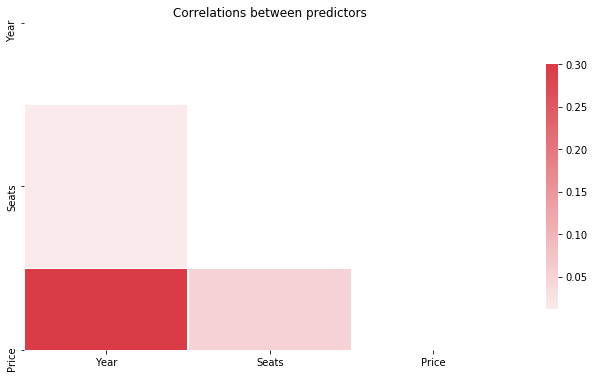

In [10]:
corr_df = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between predictors')
plt.show()

In [ ]:
# plots of accomodates, bathrooms, bedrooms and beds
cols = ['accommodates','bathrooms', 'bedrooms', 'beds']
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(8,5))
fig.tight_layout()
for i in range(len(cols)):
    data_plot = data.dropna(subset = [cols[i]])
    sns.distplot(data_plot[cols[i]], ax=axes[i,0])
    sns.boxplot(data_plot[cols[i]], ax=axes[i,1])
fig.show()

In [ ]:
# Determine missing entries in each column
data.isnull().sum()

In [ ]:
# We can observe a significant number of nulls in host_response_rate and
# review_scores_rating. As this will have a high probability of skewing
# our model, we will be dropping these columns in the DataFrameMapper later
# on.

In [ ]:
# check categorical features (objects)
#data.select_dtypes(include =['object'])

def check_categorial(col_name):
    print('\n' + col_name)
    print(data[col_name].value_counts())
    
# Analyse types of each categorial features
for col in data.columns[data.dtypes == 'object']:
    check_categorial(col)

In [ ]:
target = 'price'
X = data.drop(target, axis=1)
y = data[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

### Preprocessing 
Using StandardScaler, LabelBinarizer, SimpleImputer, Categorical Imputer.

In [ ]:
# Grab all column names
# pd.DataFrame(data.dtypes).sort_values(0).to_dict()[0]

In [ ]:
# Excluding columns ID, Longitude, Latitude, zipcode (information is captured
# in city), Description, Name (both are subjective categories)

In [ ]:
# some columns are # out to play around with the regressors
mapper = DataFrameMapper ([
   ('cleaning_fee',[CategoricalImputer(), LabelBinarizer()]),
   (['number_of_reviews'], [SimpleImputer(),PolynomialFeatures(degree =5, include_bias=False),StandardScaler()]),
   (['accommodates'], [SimpleImputer(strategy='most_frequent'),PolynomialFeatures(degree =5,include_bias=False),StandardScaler()]),
   (['bedrooms'], [SimpleImputer(strategy='median'),PolynomialFeatures(degree =5,include_bias=False), StandardScaler()]),
   (['beds'], [SimpleImputer(strategy='median'), PolynomialFeatures(degree =5,include_bias=False),StandardScaler()]),
   (['bathrooms'], [SimpleImputer(strategy='median'), PolynomialFeatures(degree =5,include_bias=False),StandardScaler()]),
   ('host_has_profile_pic', [CategoricalImputer(), LabelBinarizer()]),
   ('cancellation_policy', [CategoricalImputer(), LabelBinarizer()]),
#   ('host_since', [CategoricalImputer(), LabelBinarizer()]),
   ('instant_bookable', [CategoricalImputer(), LabelBinarizer()]),
   ('bed_type', [CategoricalImputer(), LabelBinarizer()]),
#   ('neighbourhood', [CategoricalImputer(), LabelBinarizer()]),
#   ('amenities', [LabelBinarizer()]),
   ('room_type', [CategoricalImputer(), LabelBinarizer()]),
   ('property_type', [CategoricalImputer(), LabelBinarizer()]),
   ('city', [CategoricalImputer(), LabelBinarizer()]),
   ('host_identity_verified', [CategoricalImputer(), LabelBinarizer()])
   ], df_out=True
 )

In [ ]:
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

## 5. Model the data <a class="anchor" id="fifth-bullet"></a>

In [ ]:
# Linear Regression
model = LinearRegression().fit(Z_train, y_train)
model.score(Z_train, y_train)

In [ ]:
model.score(Z_test, y_test)

In [ ]:
model.predict(Z_train)

In [ ]:
# LASSO
# Set up a list of LASSO alphas to check.
l_alphas = np.linspace(0, 5, 200)

# Cross-validate over our list of Lasso alphas.
lasso = LassoCV(alphas=l_alphas, cv=10, verbose=1)
lasso.fit(Z_train, y_train)
lasso_alpha = lasso.alpha_
print(lasso_alpha)
# Fit model using best lasso alpha!

In [ ]:
# Instantiate LASSO model.
lasso_opt = Lasso(alpha=lasso_alpha)

lasso_scores = cross_val_score(lasso_opt, Z_train, y_train, cv=10)

In [ ]:
lasso_opt.fit(Z_train, y_train)

In [ ]:
lasso_opt.score(Z_train, y_train)

In [ ]:
lasso_opt.score(Z_test, y_test)

In [ ]:
lasso_opt.predict(Z_train)

In [ ]:
# RANSAC Regressor
reg = RANSACRegressor(random_state=42).fit(Z_train, y_train)

In [ ]:
reg.score(Z_train, y_train)

In [ ]:
reg.predict(Z_train)

In [ ]:
# To predict prices for 'test' data set and submit to Kaggle
df_submit = pd.read_csv('data/test.csv')

In [ ]:
Z_submit = mapper.transform(df_submit)

In [ ]:
Z_submit.isnull().sum()

In [ ]:
# Using LASSO as an example and add in price column
df_submit['price'] = lasso_opt.predict(Z_submit) 
df_submit

In [ ]:
# output to CSV
df_submit[['id', 'price']].to_csv('AT-2019-12-15-2.csv', index=False)

## 6. Conclusion <a class="anchor" id="sixth-bullet"></a>

In [ ]:
# Lasso looks to be the better model for this data. This is due to
# the regressor's ability to identify columns that do not heavily
# affect predictions and to drop those columns entirely in the model.